In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset as BaseDataset
from torchvision import transforms as T

import torchvision.transforms as tvtransforms

import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as albu

import time
import os
from tqdm.notebook import tqdm

from torch.utils.data import Dataset as BaseDataset
import segmentation_models_pytorch as smp

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ['CUDA_VISIBLE_DEVICES'] = '1, 2, 3'
device

device(type='cuda')

In [4]:
train_dir = './train.txt'
val_dir = './val.txt'
test_dir = './test.txt'

f = open(train_dir, newline='')
train = f.readlines()
train = [i.rstrip('\n') for i in train]

f = open(val_dir, newline='')
val = f.readlines()
val = [i.rstrip('\n') for i in val]

f = open(test_dir, newline='')
test = f.readlines()
test = [i.rstrip('\n') for i in test]

#Train用、Val用、Test用の画像数の確認
print(len(train), len(val), len(test))

86 12 25


In [6]:
x_train = train
y_train = [s.replace('_img', '').replace('image', 'mask') for s in train]

x_valid = val
y_valid = [s.replace('_img', '').replace('image', 'mask') for s in val]

x_test = test
y_test = [s.replace('_img', '').replace('image', 'mask') for s in test]

In [9]:
class Dataset(BaseDataset):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    CLASSES = ['__background__', 'braille_blocks']

    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            
    ):
    
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        self.mapping = [
                    [0, 0, 0],
                    [0, 0, 128] # 点字ブロック
                ]

    def mask_to_class_rgb(self, mask):
        print('----mask->rgb----')
        mask = torch.from_numpy(np.array(mask))
        mask = torch.squeeze(mask)

        print('unique values rgb    ', torch.unique(mask)) 

        class_mask = mask
        class_mask = class_mask.permute(2, 0, 1).contiguous()
        h, w = class_mask.shape[1], class_mask.shape[2]
        mask_out = torch.empty(h, w, dtype=torch.long)

        for k in self.mapping:
            idx = (class_mask == torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))         
            validx = (idx.sum(0) == 4)          
            mask_out[validx] = torch.tensor(self.mapping[k], dtype=torch.long)

        print('unique values mapped ', torch.unique(mask_out))
        
        return mask_out
    
    def __getitem__(self, i):
        
        # 画像読み込み
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # ファイル名がマスク画像と元画像で違うため整合性を取る処理
        self.masks_fps[i] = self.masks_fps[i].replace("_img", "")
        mask = cv2.imread(self.masks_fps[i])

        image_pad = np.zeros((image.shape[0]+8, image.shape[1], image.shape[2]), dtype=np.uint8)
        image_pad[0:-8] = image
        mask_pad = np.zeros((mask.shape[0]+8, mask.shape[1], mask.shape[2]), dtype=np.uint8)
        mask_pad[0:-8] = mask

        image = image_pad
        mask = mask_pad

        image_mask = np.zeros(mask.shape, dtype=np.int8)

        for i, c in enumerate(self.mapping):
            image_mask[np.where((mask == c).all(axis=2))] = (i, 0, 0)
        
        mask = image_mask[:, :, 0]

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        image = t(image)
        mask = torch.from_numpy(mask).long()     
            
        return image, mask

        
    def __len__(self):
        return len(self.ids)

In [10]:
import shutil

make_dir_list = ['train', 'train_anno', 'val', 'val_anno', 'test', 'test_anno']
copy_img_list = [x_train, y_train, x_valid, y_valid, x_test, y_test]

for i, j in zip(make_dir_list, copy_img_list):
    os.makedirs(f'./{i}', exist_ok=True)   
    for k in j:
        shutil.copy(f'{k}', f'./{i}/')



In [11]:
x_train_dir = os.path.join('./', 'train')
y_train_dir = os.path.join('./', 'train_anno')

x_valid_dir = os.path.join('./', 'val')
y_valid_dir = os.path.join('./', 'val_anno')

x_test_dir = os.path.join('./', 'test')
y_test_dir = os.path.join('./', 'test_anno')

In [12]:
#Trainデータの確認

dataset = Dataset(x_train_dir, y_train_dir, classes=['braille_blocks'])

image, mask = dataset[0] # get some sample

In [13]:
#画像およびマスクの表示用関数

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


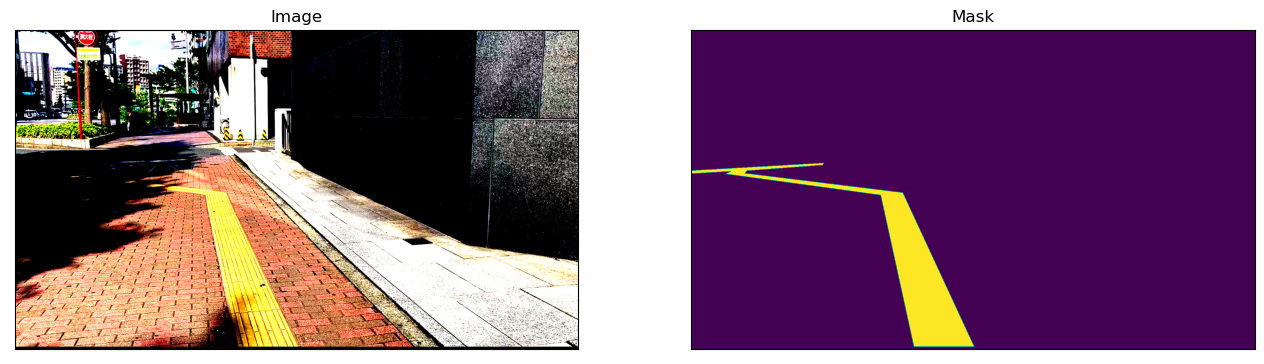

In [14]:
# Datasetの画像とマスクの確認。

dataset = Dataset(x_train_dir, y_train_dir, classes=['braille_blocks'])

image, mask = dataset[0] # get some sample
visualize(
    image=image.permute(1, 2, 0), #To tensorでchannel, h, wが画像表示用と異なるため、配列変換
    mask=mask
)


In [15]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480),
        
    ]
    return albu.Compose(test_transform)

def test_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    #test_transform = [
    #   albu.PadIfNeeded(384, 480)
    #]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/home/sozolab/anaconda3/envs/py36/lib/python3.10/site-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/home/sozolab/anaconda3/envs/py36/lib/python3.10/site-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/home/sozolab/anaconda3/envs/py36/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/sozolab/anaconda3/envs/py36/lib/python3.10/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is depreca

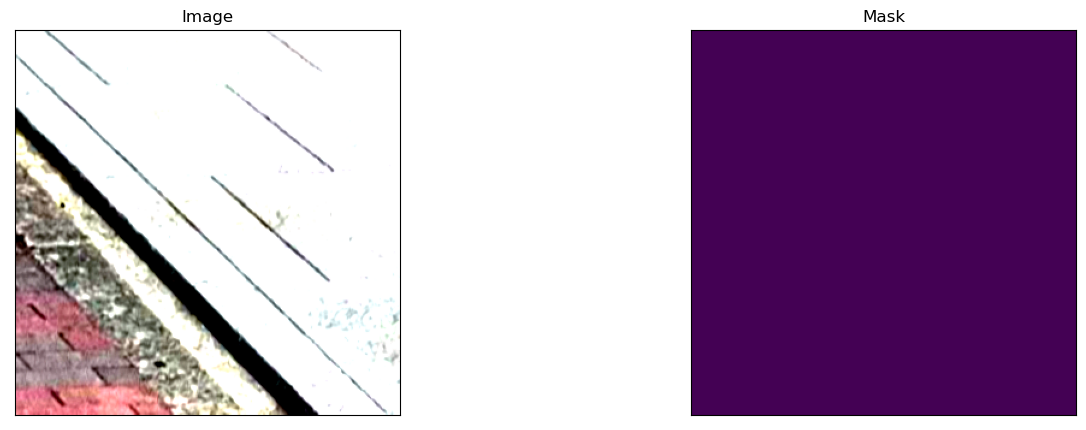

86
320


In [16]:
# Augumentation処理後の画像の確認

dataset = Dataset(x_train_dir, y_train_dir, classes=['braille_blocks'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image.permute(1, 2, 0), 
    mask=mask
)
print(len(dataset))
print(len(mask))

In [17]:
#画像サイズの確認

image.shape

torch.Size([3, 320, 320])

## Create model and train

In [18]:
#画像のクラスを設定

CLASSES = ['__background__', 'braille_blocks']
len(CLASSES)

2

In [19]:
#Semantic Segmentationのモデルを設定

model = smp.Unet('efficientnet-b4', encoder_weights='imagenet', classes=len(CLASSES), activation=None)
model = torch.nn.DataParallel(model, device_ids=[0,1,2,3])

In [20]:
#Train, Validationのデータセットを作成

train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [21]:
print(len(train_dataset))
print(len(valid_dataset))

86
12


## Training

In [22]:
# # Create dummy target image
# nb_classes = 5 - 1 # 18 classes + background
# idx = np.linspace(0., 1., nb_classes)
# cmap = plt.cm.get_cmap('viridis')
# rgb = cmap(idx, bytes=True)[:, :3]  # Remove alpha value

# h, w = 190, 100
# rgb = rgb.repeat(1000, 0)
# target = np.zeros((h*w, 3), dtype=np.uint8)
# target[:rgb.shape[0]] = rgb
# target = target.reshape(h, w, 3)

# plt.imshow(target) # Each class in 10 rows

# # Create mapping
# # Get color codes for dataset (maybe you would have to use more than a single
# # image, if it doesn't contain all classes)
# target = torch.from_numpy(target)
# colors = torch.unique(target.view(-1, target.size(2)), dim=0).numpy()
# target = target.permute(2, 0, 1).contiguous()

# mapping = {tuple(c): t for c, t in zip(colors.tolist(), range(len(colors)))}

# mask = torch.empty(h, w, dtype=torch.long)
# for k in mapping:
#     # Get all indices for current class
#     idx = (target==torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))
#     validx = (idx.sum(0) == 3)  # Check that all channels match
#     mask[validx] = torch.tensor(mapping[k], dtype=torch.long)
# print(mask, mask.shape)

In [23]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [24]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=len(CLASSES)):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [25]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    # model.to(device)
    model.to(f'cuda:{model.device_ids[0]}')
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            # print(output.shape)
            # print(mask.shape)
            # print(mask.min(), mask.max())
            loss = criterion(output, mask)
            # output_probs = F.sigmoid(output)
            # output_flat = output_probs.view(output_probs.size(0),-1)
            # mask_flat = mask.view(mask.size(0),-1)
            # print(output_flat.shape)
            # print(mask_flat.shape)
            # print(output_flat.size(0))
            # print(mask_flat.size(0))
            # loss = criterion(output_flat, mask_flat)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    #torch.save(model, 'Unet-_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader))) #Train途中もモデルを保存するときは実行する
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 20:
                    print('Loss not decrease for 20 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [26]:
%%bash
nvidia-smi

Fri Dec 23 15:10:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:18:00.0 Off |                  N/A |
| 19%   23C    P8     1W / 250W |     13MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 18%   

In [27]:
max_lr = 1e-3
epoch = 200
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, valid_loader, criterion, optimizer, sched)

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.578 
Epoch:1/200.. Train Loss: 0.611.. Val Loss: 0.578.. Train mIoU:0.439.. Val mIoU: 0.378.. Train Acc:0.683.. Val Acc:0.696.. Time: 0.33m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.578 >> 0.468 
Epoch:2/200.. Train Loss: 0.552.. Val Loss: 0.468.. Train mIoU:0.491.. Val mIoU: 0.461.. Train Acc:0.747.. Val Acc:0.814.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.468 >> 0.417 
Epoch:3/200.. Train Loss: 0.500.. Val Loss: 0.417.. Train mIoU:0.497.. Val mIoU: 0.503.. Train Acc:0.790.. Val Acc:0.866.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.417 >> 0.376 
saving model...
Epoch:4/200.. Train Loss: 0.459.. Val Loss: 0.376.. Train mIoU:0.560.. Val mIoU: 0.525.. Train Acc:0.833.. Val Acc:0.891.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.376 >> 0.302 
Epoch:5/200.. Train Loss: 0.429.. Val Loss: 0.302.. Train mIoU:0.607.. Val mIoU: 0.581.. Train Acc:0.844.. Val Acc:0.927.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.302 >> 0.273 
Epoch:6/200.. Train Loss: 0.400.. Val Loss: 0.273.. Train mIoU:0.604.. Val mIoU: 0.590.. Train Acc:0.864.. Val Acc:0.936.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.273 >> 0.259 
Epoch:7/200.. Train Loss: 0.388.. Val Loss: 0.259.. Train mIoU:0.634.. Val mIoU: 0.593.. Train Acc:0.873.. Val Acc:0.940.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.259 >> 0.241 
Epoch:8/200.. Train Loss: 0.321.. Val Loss: 0.241.. Train mIoU:0.619.. Val mIoU: 0.618.. Train Acc:0.909.. Val Acc:0.947.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.241 >> 0.194 
saving model...
Epoch:9/200.. Train Loss: 0.308.. Val Loss: 0.194.. Train mIoU:0.641.. Val mIoU: 0.657.. Train Acc:0.912.. Val Acc:0.956.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.194 >> 0.185 
Epoch:10/200.. Train Loss: 0.293.. Val Loss: 0.185.. Train mIoU:0.612.. Val mIoU: 0.688.. Train Acc:0.910.. Val Acc:0.957.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.185 >> 0.166 
Epoch:11/200.. Train Loss: 0.261.. Val Loss: 0.166.. Train mIoU:0.713.. Val mIoU: 0.709.. Train Acc:0.929.. Val Acc:0.964.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.166 >> 0.160 
Epoch:12/200.. Train Loss: 0.240.. Val Loss: 0.160.. Train mIoU:0.625.. Val mIoU: 0.730.. Train Acc:0.937.. Val Acc:0.969.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.160 >> 0.156 
Epoch:13/200.. Train Loss: 0.228.. Val Loss: 0.156.. Train mIoU:0.621.. Val mIoU: 0.727.. Train Acc:0.937.. Val Acc:0.966.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.156 >> 0.130 
saving model...
Epoch:14/200.. Train Loss: 0.191.. Val Loss: 0.130.. Train mIoU:0.718.. Val mIoU: 0.686.. Train Acc:0.949.. Val Acc:0.968.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.130 >> 0.122 
Epoch:15/200.. Train Loss: 0.180.. Val Loss: 0.122.. Train mIoU:0.703.. Val mIoU: 0.781.. Train Acc:0.953.. Val Acc:0.976.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.122 >> 0.106 
Epoch:16/200.. Train Loss: 0.147.. Val Loss: 0.106.. Train mIoU:0.746.. Val mIoU: 0.801.. Train Acc:0.964.. Val Acc:0.978.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.106 >> 0.090 
Epoch:17/200.. Train Loss: 0.152.. Val Loss: 0.090.. Train mIoU:0.716.. Val mIoU: 0.874.. Train Acc:0.962.. Val Acc:0.987.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:18/200.. Train Loss: 0.162.. Val Loss: 0.103.. Train mIoU:0.747.. Val mIoU: 0.779.. Train Acc:0.957.. Val Acc:0.976.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:19/200.. Train Loss: 0.161.. Val Loss: 0.123.. Train mIoU:0.759.. Val mIoU: 0.829.. Train Acc:0.955.. Val Acc:0.978.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.123 >> 0.088 
Epoch:20/200.. Train Loss: 0.149.. Val Loss: 0.088.. Train mIoU:0.719.. Val mIoU: 0.833.. Train Acc:0.959.. Val Acc:0.983.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:21/200.. Train Loss: 0.162.. Val Loss: 0.117.. Train mIoU:0.688.. Val mIoU: 0.747.. Train Acc:0.953.. Val Acc:0.964.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.117 >> 0.097 
saving model...
Epoch:22/200.. Train Loss: 0.116.. Val Loss: 0.097.. Train mIoU:0.726.. Val mIoU: 0.824.. Train Acc:0.969.. Val Acc:0.981.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.097 >> 0.072 
Epoch:23/200.. Train Loss: 0.123.. Val Loss: 0.072.. Train mIoU:0.714.. Val mIoU: 0.843.. Train Acc:0.965.. Val Acc:0.985.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.072 >> 0.066 
Epoch:24/200.. Train Loss: 0.113.. Val Loss: 0.066.. Train mIoU:0.756.. Val mIoU: 0.881.. Train Acc:0.967.. Val Acc:0.989.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:25/200.. Train Loss: 0.078.. Val Loss: 0.105.. Train mIoU:0.799.. Val mIoU: 0.807.. Train Acc:0.980.. Val Acc:0.971.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.105 >> 0.087 
Epoch:26/200.. Train Loss: 0.127.. Val Loss: 0.087.. Train mIoU:0.786.. Val mIoU: 0.710.. Train Acc:0.959.. Val Acc:0.970.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.087 >> 0.075 
Epoch:27/200.. Train Loss: 0.208.. Val Loss: 0.075.. Train mIoU:0.689.. Val mIoU: 0.849.. Train Acc:0.935.. Val Acc:0.981.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:28/200.. Train Loss: 0.111.. Val Loss: 0.113.. Train mIoU:0.797.. Val mIoU: 0.651.. Train Acc:0.969.. Val Acc:0.964.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.113 >> 0.079 
saving model...
Epoch:29/200.. Train Loss: 0.117.. Val Loss: 0.079.. Train mIoU:0.785.. Val mIoU: 0.811.. Train Acc:0.970.. Val Acc:0.979.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:30/200.. Train Loss: 0.169.. Val Loss: 5.006.. Train mIoU:0.747.. Val mIoU: 0.482.. Train Acc:0.949.. Val Acc:0.944.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 5.006 >> 0.270 
Epoch:31/200.. Train Loss: 0.132.. Val Loss: 0.270.. Train mIoU:0.771.. Val mIoU: 0.563.. Train Acc:0.963.. Val Acc:0.951.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Epoch:32/200.. Train Loss: 0.100.. Val Loss: 0.533.. Train mIoU:0.868.. Val mIoU: 0.495.. Train Acc:0.971.. Val Acc:0.952.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.533 >> 0.081 
Epoch:33/200.. Train Loss: 0.103.. Val Loss: 0.081.. Train mIoU:0.762.. Val mIoU: 0.775.. Train Acc:0.976.. Val Acc:0.975.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Not Decrease for 8 time
Epoch:34/200.. Train Loss: 0.107.. Val Loss: 0.147.. Train mIoU:0.823.. Val mIoU: 0.710.. Train Acc:0.976.. Val Acc:0.965.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.147 >> 0.142 
Epoch:35/200.. Train Loss: 0.070.. Val Loss: 0.142.. Train mIoU:0.816.. Val mIoU: 0.625.. Train Acc:0.982.. Val Acc:0.962.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.142 >> 0.072 
Epoch:36/200.. Train Loss: 0.112.. Val Loss: 0.072.. Train mIoU:0.844.. Val mIoU: 0.809.. Train Acc:0.973.. Val Acc:0.981.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.072 >> 0.071 
saving model...
Epoch:37/200.. Train Loss: 0.095.. Val Loss: 0.071.. Train mIoU:0.807.. Val mIoU: 0.810.. Train Acc:0.974.. Val Acc:0.981.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Not Decrease for 9 time
Epoch:38/200.. Train Loss: 0.118.. Val Loss: 0.301.. Train mIoU:0.810.. Val mIoU: 0.617.. Train Acc:0.966.. Val Acc:0.959.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.301 >> 0.115 
Epoch:39/200.. Train Loss: 0.088.. Val Loss: 0.115.. Train mIoU:0.808.. Val mIoU: 0.748.. Train Acc:0.977.. Val Acc:0.974.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Not Decrease for 10 time
Epoch:40/200.. Train Loss: 0.128.. Val Loss: 0.131.. Train mIoU:0.855.. Val mIoU: 0.784.. Train Acc:0.964.. Val Acc:0.969.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.131 >> 0.064 
Epoch:41/200.. Train Loss: 0.100.. Val Loss: 0.064.. Train mIoU:0.809.. Val mIoU: 0.858.. Train Acc:0.983.. Val Acc:0.986.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Not Decrease for 11 time
Epoch:42/200.. Train Loss: 0.150.. Val Loss: 0.157.. Train mIoU:0.750.. Val mIoU: 0.684.. Train Acc:0.950.. Val Acc:0.946.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.157 >> 0.071 
Epoch:43/200.. Train Loss: 0.164.. Val Loss: 0.071.. Train mIoU:0.761.. Val mIoU: 0.786.. Train Acc:0.953.. Val Acc:0.978.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.071 >> 0.068 
Epoch:44/200.. Train Loss: 0.122.. Val Loss: 0.068.. Train mIoU:0.796.. Val mIoU: 0.812.. Train Acc:0.972.. Val Acc:0.980.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Not Decrease for 12 time
Epoch:45/200.. Train Loss: 0.116.. Val Loss: 0.070.. Train mIoU:0.803.. Val mIoU: 0.730.. Train Acc:0.971.. Val Acc:0.974.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Not Decrease for 13 time
Epoch:46/200.. Train Loss: 0.099.. Val Loss: 0.095.. Train mIoU:0.852.. Val mIoU: 0.541.. Train Acc:0.978.. Val Acc:0.957.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.095 >> 0.094 
saving model...
Epoch:47/200.. Train Loss: 0.095.. Val Loss: 0.094.. Train mIoU:0.795.. Val mIoU: 0.618.. Train Acc:0.973.. Val Acc:0.961.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.094 >> 0.071 
Epoch:48/200.. Train Loss: 0.131.. Val Loss: 0.071.. Train mIoU:0.785.. Val mIoU: 0.822.. Train Acc:0.972.. Val Acc:0.977.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.071 >> 0.071 
Epoch:49/200.. Train Loss: 0.100.. Val Loss: 0.071.. Train mIoU:0.815.. Val mIoU: 0.845.. Train Acc:0.973.. Val Acc:0.982.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.071 >> 0.053 
Epoch:50/200.. Train Loss: 0.113.. Val Loss: 0.053.. Train mIoU:0.774.. Val mIoU: 0.847.. Train Acc:0.972.. Val Acc:0.983.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Not Decrease for 14 time
Epoch:51/200.. Train Loss: 0.098.. Val Loss: 0.110.. Train mIoU:0.787.. Val mIoU: 0.801.. Train Acc:0.970.. Val Acc:0.968.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.110 >> 0.073 
Epoch:52/200.. Train Loss: 0.120.. Val Loss: 0.073.. Train mIoU:0.782.. Val mIoU: 0.725.. Train Acc:0.969.. Val Acc:0.974.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.073 >> 0.061 
saving model...
Epoch:53/200.. Train Loss: 0.064.. Val Loss: 0.061.. Train mIoU:0.893.. Val mIoU: 0.881.. Train Acc:0.983.. Val Acc:0.986.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.061 >> 0.061 
Epoch:54/200.. Train Loss: 0.077.. Val Loss: 0.061.. Train mIoU:0.820.. Val mIoU: 0.855.. Train Acc:0.982.. Val Acc:0.981.. Time: 0.21m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Not Decrease for 15 time
Epoch:55/200.. Train Loss: 0.112.. Val Loss: 0.120.. Train mIoU:0.851.. Val mIoU: 0.767.. Train Acc:0.966.. Val Acc:0.962.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Not Decrease for 16 time
Epoch:56/200.. Train Loss: 0.166.. Val Loss: 0.124.. Train mIoU:0.739.. Val mIoU: 0.745.. Train Acc:0.949.. Val Acc:0.970.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.124 >> 0.090 
Epoch:57/200.. Train Loss: 0.143.. Val Loss: 0.090.. Train mIoU:0.670.. Val mIoU: 0.777.. Train Acc:0.955.. Val Acc:0.972.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Not Decrease for 17 time
Epoch:58/200.. Train Loss: 0.113.. Val Loss: 0.102.. Train mIoU:0.836.. Val mIoU: 0.741.. Train Acc:0.974.. Val Acc:0.970.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.102 >> 0.081 
Epoch:59/200.. Train Loss: 0.053.. Val Loss: 0.081.. Train mIoU:0.867.. Val mIoU: 0.729.. Train Acc:0.987.. Val Acc:0.973.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.081 >> 0.067 
Epoch:60/200.. Train Loss: 0.041.. Val Loss: 0.067.. Train mIoU:0.888.. Val mIoU: 0.793.. Train Acc:0.990.. Val Acc:0.978.. Time: 0.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Decreasing.. 0.067 >> 0.053 
saving model...
Epoch:61/200.. Train Loss: 0.085.. Val Loss: 0.053.. Train mIoU:0.751.. Val mIoU: 0.889.. Train Acc:0.980.. Val Acc:0.989.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Not Decrease for 18 time
Epoch:62/200.. Train Loss: 0.113.. Val Loss: 0.070.. Train mIoU:0.841.. Val mIoU: 0.836.. Train Acc:0.974.. Val Acc:0.980.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Not Decrease for 19 time
Epoch:63/200.. Train Loss: 0.104.. Val Loss: 0.072.. Train mIoU:0.788.. Val mIoU: 0.849.. Train Acc:0.977.. Val Acc:0.985.. Time: 0.20m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Loss Not Decrease for 20 time
Loss not decrease for 20 times, Stop Training
Total time: 12.62 m


In [28]:
torch.save(model, './model/Unet-efficientb4_aiseminar.pt')

In [29]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

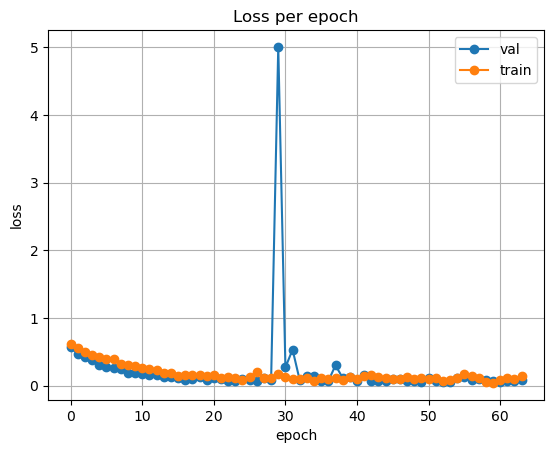

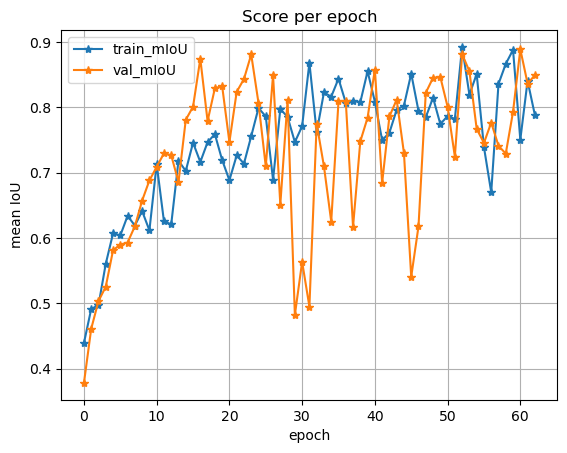

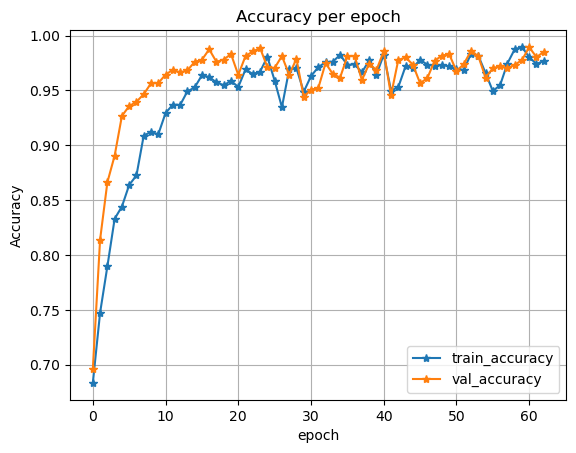

In [30]:
plot_loss(history)
plot_score(history)
plot_acc(history)

## Evaluation

## Test best saved model

In [31]:
# load best saved checkpoint
model = torch.load('./model/Unet-efficientb4_aiseminar.pt')

In [32]:
class testDataset(BaseDataset):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    CLASSES = ['__background__', 'braille_blocks']

    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        self.mapping = [
                    [0, 0, 0],
                    [0, 0, 128] # 点字ブロック
                ]
    
    def mask_to_class_rgb(self, mask):
        print('----mask->rgb----')
        mask = torch.from_numpy(np.array(mask))
        mask = torch.squeeze(mask)  # remove 1

        # check the present values in the mask, 0 and 255 in my case
        print('unique values rgb    ', torch.unique(mask)) 
        # -> unique values rgb     tensor([  0, 255], dtype=torch.uint8)

        class_mask = mask
        class_mask = class_mask.permute(2, 0, 1).contiguous()
        h, w = class_mask.shape[1], class_mask.shape[2]
        mask_out = torch.empty(h, w, dtype=torch.long)

        for k in self.mapping:
            idx = (class_mask == torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))         
            validx = (idx.sum(0) == 4)          
            mask_out[validx] = torch.tensor(self.mapping[k], dtype=torch.long)

        # check the present values after mapping, in my case 0, 1, 2, 3
        print('unique values mapped ', torch.unique(mask_out))
        # -> unique values mapped  tensor([0, 1, 2, 3])
        
        return mask_out
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        self.masks_fps[i] = self.masks_fps[i].replace("_img", "")
        mask = cv2.imread(self.masks_fps[i])

        image_pad = np.zeros((image.shape[0]+8, image.shape[1], image.shape[2]), dtype=np.uint8)
        image_pad[0:-8] = image
        mask_pad = np.zeros((mask.shape[0]+8, mask.shape[1], mask.shape[2]), dtype=np.uint8)
        mask_pad[0:-8] = mask

        image = image_pad
        mask = mask_pad
        
        image_mask = np.zeros(mask.shape, dtype=np.int8)

        for i, c in enumerate(self.mapping):
            image_mask[np.where((mask == c).all(axis=2))] = (i, 0, 0)
        
        mask = image_mask[:, :, 0]

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        #t = T.Compose([T.ToTensor()])
        #image = t(image)
        # t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        # image = t(image)
        mask = torch.from_numpy(mask).long()
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [33]:
# create test dataset
test_dataset = testDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    #preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [34]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [35]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [36]:
image, mask = test_dataset[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [37]:
image, mask = test_dataset[3]
image.shape

(1088, 1920, 3)

In [38]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [39]:
mob_miou = miou_score(model, test_dataset)
print('Test Set mIoU', np.mean(mob_miou))

  0%|          | 0/25 [00:00<?, ?it/s]

Test Set mIoU 0.7336293933714353


In [40]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [41]:
mob_acc = pixel_acc(model, test_dataset)
print('Test Set Pixel Accuracy', np.mean(mob_acc))

  0%|          | 0/25 [00:00<?, ?it/s]

Test Set Pixel Accuracy 0.9685633425245098


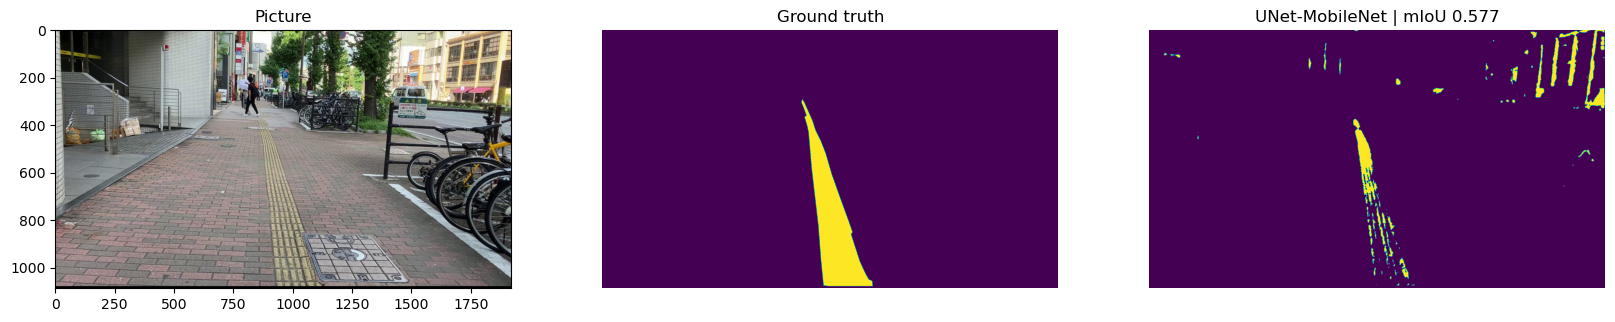

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

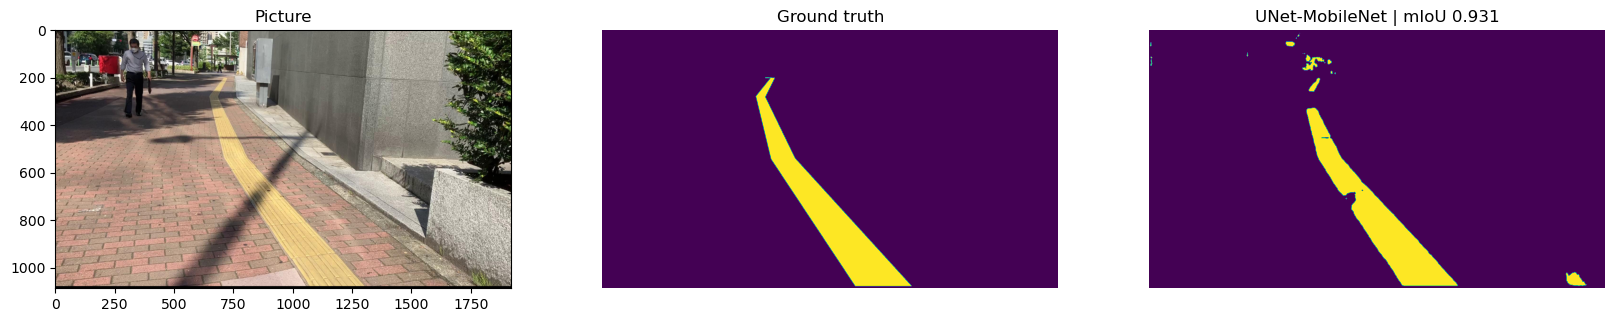

In [43]:
image2, mask2 = test_dataset[15]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

In [44]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

UNet-EfficientNet-B4 | mIoU 0.658


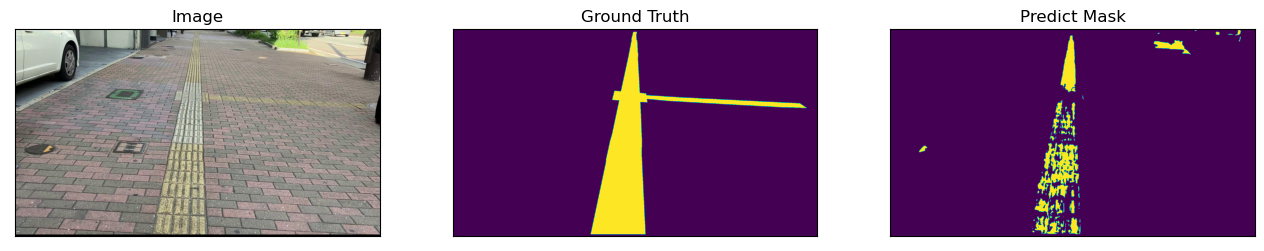

UNet-EfficientNet-B4 | mIoU 0.886


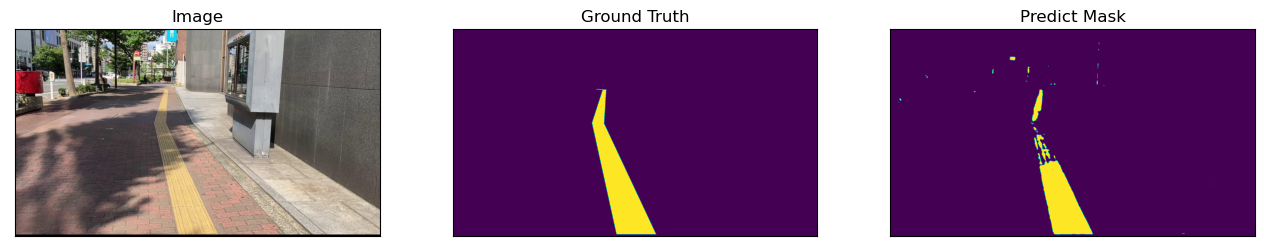

UNet-EfficientNet-B4 | mIoU 0.874


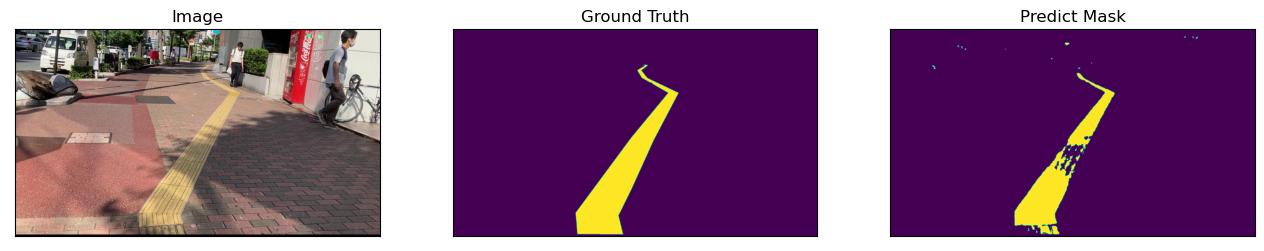

UNet-EfficientNet-B4 | mIoU 0.639


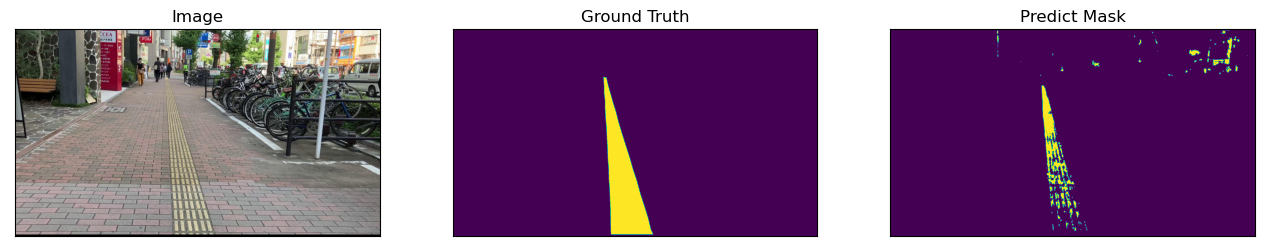

In [45]:
for i in range(4):
    n = np.random.choice(len(test_dataset))
    
    image2, mask2 = test_dataset[n]
    
    pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)
    
    print('UNet-EfficientNet-B4 | mIoU {:.3f}'.format(score2))
    
    visualize(
        image=image2, 
        ground_truth=mask2,
        predict_mask = pred_mask2,
    )
    